<a href="https://colab.research.google.com/github/ChonnaveeSuk/intro-Data-Science-KMUTNB/blob/main/HW3_NLP%20Text%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Home Work 3**

Based on "yelp.csv" data, perform exploratory data analysis and use the "text" attribute only to build a classifier such as Naïve Bayes, MLP, SVM, etc. for the prediction of the "stars" attribute. Compare the classification performance and discuss the results.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
sns.set_style('darkgrid')
%config Completer.use_jedi = False

In [4]:
import warnings
warnings.filterwarnings('ignore')

**LOADING DATA**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os

# Set the search parameters
filename = 'yelp.xlsx'
search_path = '/content/drive/My Drive'

# Search for the file
for root, dirs, files in os.walk(search_path):
    if filename in files:
        file_path = os.path.join(root, filename)
        break

In [8]:
# Load the XLSX file into a DataFrame
yelp_df = pd.read_excel('yelp.xlsx')

In [ ]:
yelp_df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [9]:
yelp_df.info(verbose = True, null_counts = False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   business_id  object        
 1   date         datetime64[ns]
 2   review_id    object        
 3   stars        int64         
 4   text         object        
 5   type         object        
 6   user_id      object        
 7   cool         int64         
 8   useful       int64         
 9   funny        int64         
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 781.4+ KB


In [10]:
yelp_df.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


# Exploratory Data Analysis


In [11]:
yelp_df = yelp_df.drop(['business_id', 'date', 'review_id', 'type', 'user_id'], axis=1)
yelp_df = yelp_df.rename(columns={'stars':'Stars', 'text':'Text', 'cool':'Cool'
                                  , 'useful':'Useful', 'funny':'Funny'})
yelp_df.head()

,Stars,Text,Cool,Useful,Funny
0,5,My wife took me here on my birthday for breakf...,2,5,0
1,5,I have no idea why some people give bad review...,0,0,0
2,4,love the gyro plate. Rice is so good and I als...,0,1,0
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,2,0
4,5,General Manager Scott Petello is a good egg!!!...,0,0,0


In [12]:
yelp_df['Text Length'] = yelp_df['Text'].apply(len)
yelp_df.head()


,Stars,Text,Cool,Useful,Funny,Text Length
0,5,My wife took me here on my birthday for breakf...,2,5,0,889
1,5,I have no idea why some people give bad review...,0,0,0,1345
2,4,love the gyro plate. Rice is so good and I als...,0,1,0,76
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,2,0,419
4,5,General Manager Scott Petello is a good egg!!!...,0,0,0,469


In [13]:
yelp_df.describe()


,Stars,Cool,Useful,Funny,Text Length
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300,710.701100
std,1.214636,2.067861,2.336647,1.907942,617.434428
min,1.000000,0.000000,0.000000,0.000000,1.000000
25%,3.000000,0.000000,0.000000,0.000000,294.000000
50%,4.000000,0.000000,1.000000,0.000000,541.500000
75%,5.000000,1.000000,2.000000,1.000000,930.000000
max,5.000000,77.000000,76.000000,57.000000,4997.000000


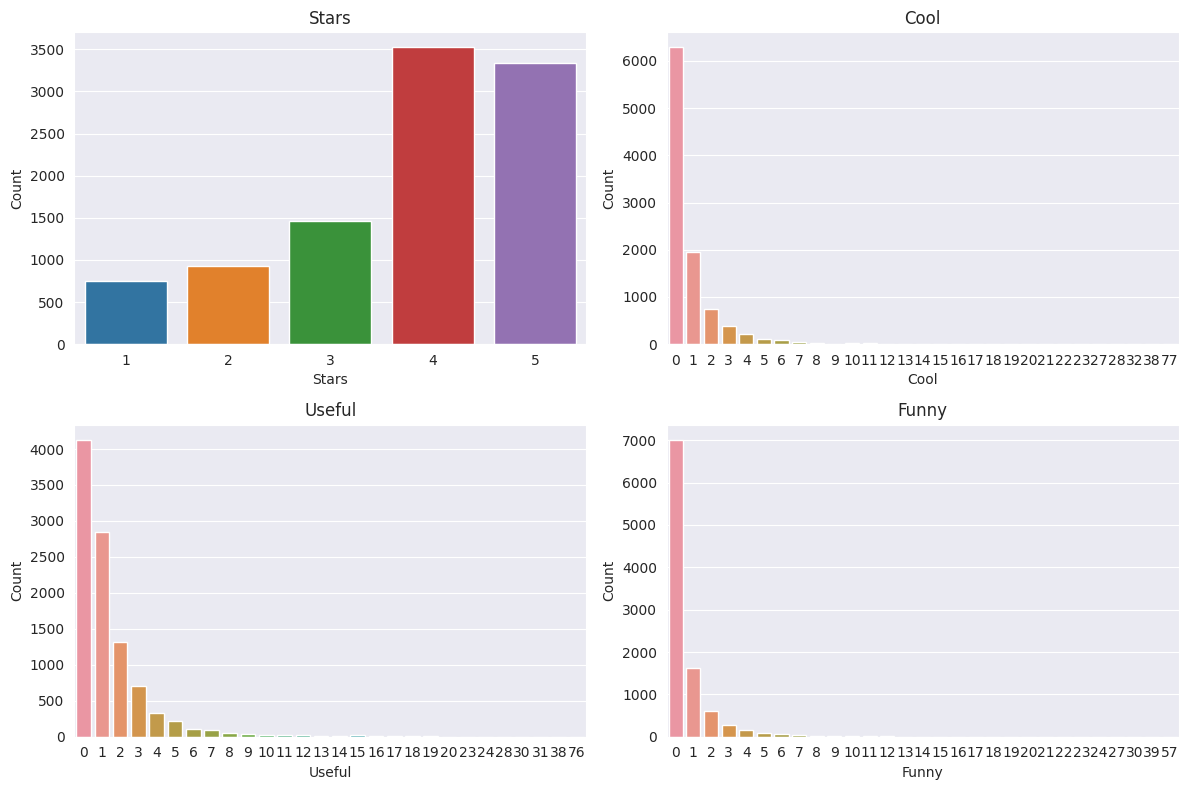

In [14]:
fig = plt.figure(figsize=(12,8))
axes1 = plt.subplot(2,2,1)
axes1 = sns.countplot(x='Stars', data=yelp_df)
axes1.set_title('Stars')
axes1.set_ylabel('Count')

axes2 = plt.subplot(2,2,2)
axes2 = sns.countplot(x='Cool', data=yelp_df)
axes2.set_title('Cool')
axes2.set_ylabel('Count')

axes3 = plt.subplot(2,2,3)
axes3 = sns.countplot(x='Useful', data=yelp_df)
axes3.set_title('Useful')
axes3.set_ylabel('Count')

axes4 = plt.subplot(2,2,4)
axes4 = sns.countplot(x='Funny', data=yelp_df)
axes4.set_title('Funny')
axes4.set_ylabel('Count')

plt.tight_layout()


Text(0.5, 1.0, 'Text Length Distribution')

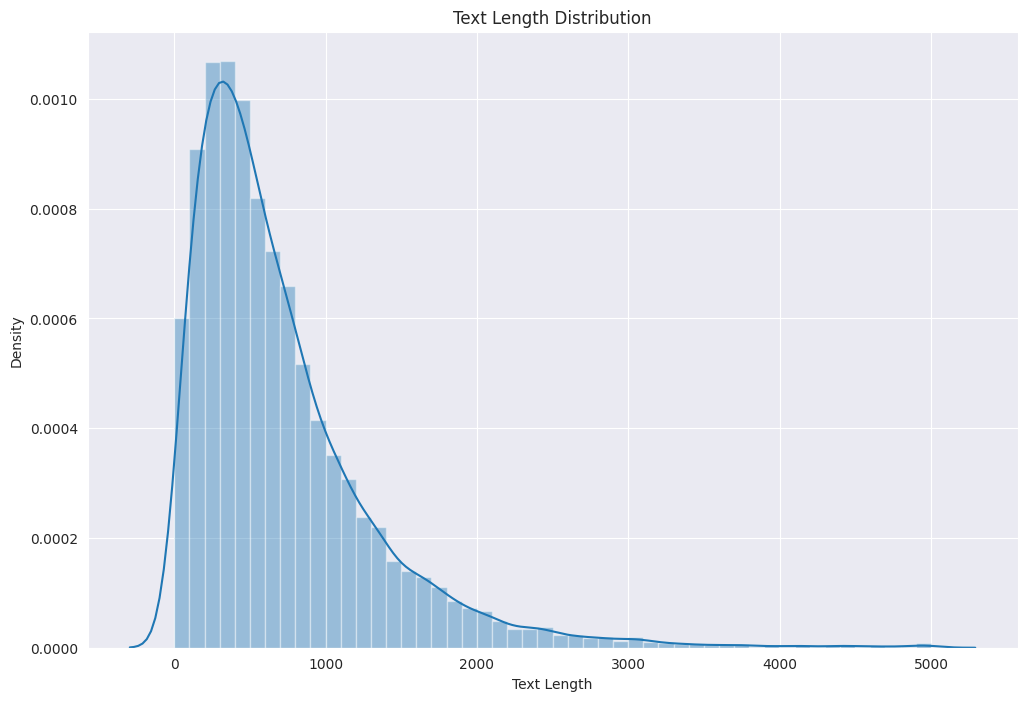

In [15]:
# Text Length
fig = plt.figure(figsize=(12,8))
sns.distplot(yelp_df['Text Length'], kde=True, bins=50)
plt.title('Text Length Distribution')

In [16]:
# Used groupby to get the mean values of the numerical columns.

stars = yelp_df.groupby('Stars').mean()
stars

,Cool,Useful,Funny,Text Length
Stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.286790
4,0.954623,1.395916,0.670448,712.904424
5,0.944261,1.381780,0.608631,624.998801


# Correlation between Label and Other Variables


Text(0.5, 1.0, 'Heatmap of Variables')

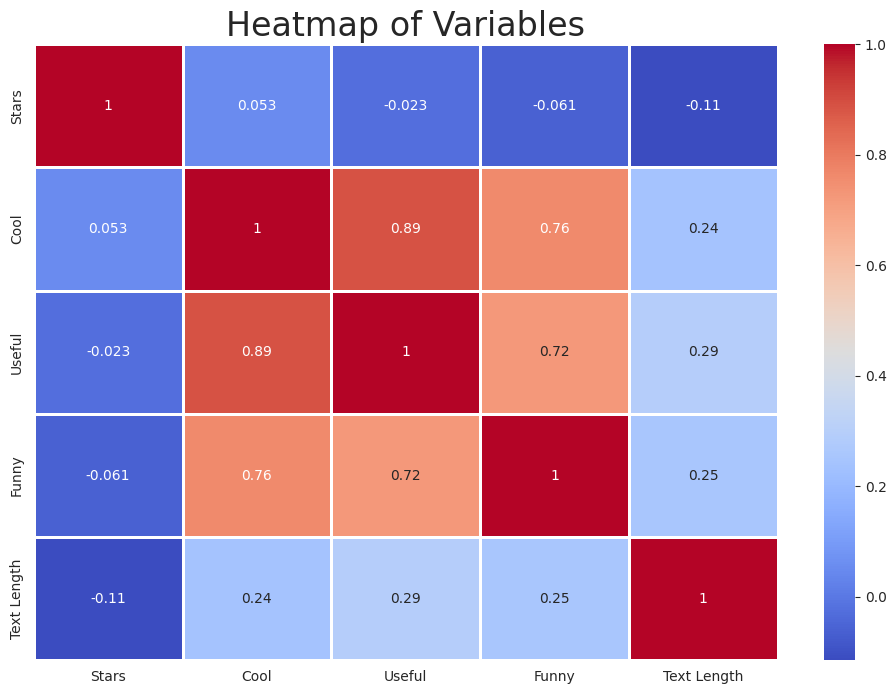

In [19]:
yelp_cor = yelp_df[['Stars', 'Cool', 'Useful', 'Funny', 'Text Length']].corr()

fig = plt.figure(figsize=(12,8))
axes = sns.heatmap(yelp_cor, cmap='coolwarm', linewidth=1, linecolor='white', annot=True)
axes.set_title('Heatmap of Variables', fontsize=24)

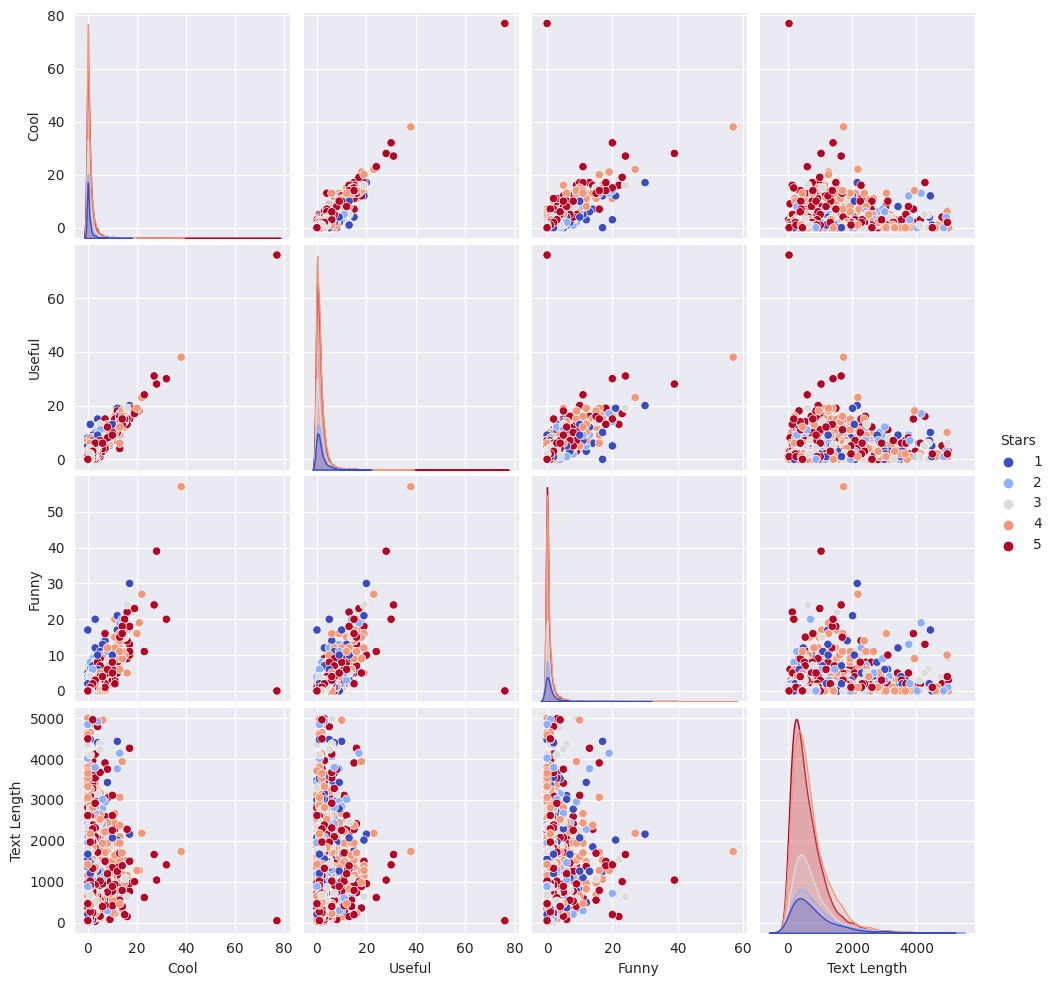

In [18]:
sns.pairplot(yelp_df, hue='Stars', palette='coolwarm')


<Axes: xlabel='Stars', ylabel='Text Length'>

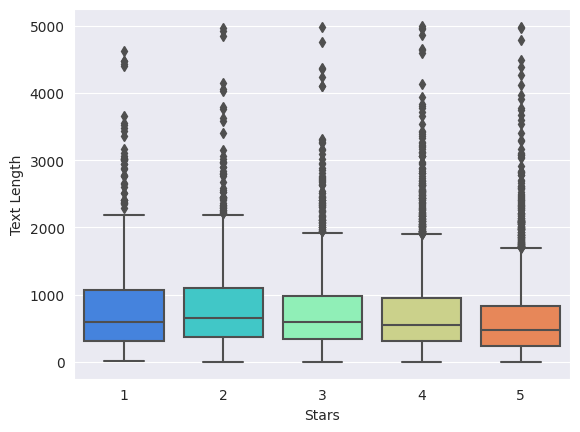

In [20]:
sns.boxplot(x='Stars', y='Text Length', data=yelp_df, palette='rainbow')

# Text Analysis


In [21]:
yelp_text = yelp_df[['Stars', 'Text']]
yelp_text.head()

,Stars,Text
0,5,My wife took me here on my birthday for breakf...
1,5,I have no idea why some people give bad review...
2,4,love the gyro plate. Rice is so good and I als...
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!..."
4,5,General Manager Scott Petello is a good egg!!!...


In [22]:
def remove_punc_stopword(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    remove_punc = [word for word in text if word not in string.punctuation]
    remove_punc = ''.join(remove_punc)
    return [word.lower() for word in remove_punc.split() if word.lower() not in stopwords.words('english')]

# All Stars Word Frequency and Word Cloud

In [23]:
yelp_text_allstars = yelp_text.copy()
yelp_text_allstars['Text'] = yelp_text_allstars['Text'].apply(remove_punc_stopword)
yelp_text_allstars.count()

Stars    10000
Text     10000
dtype: int64

In [24]:
yelp_text_allstars.head()


,Stars,Text
0,5,"[wife, took, birthday, breakfast, excellent, w..."
1,5,"[idea, people, give, bad, reviews, place, goes..."
2,4,"[love, gyro, plate, rice, good, also, dig, can..."
3,5,"[rosie, dakota, love, chaparral, dog, park, co..."
4,5,"[general, manager, scott, petello, good, egg, ..."


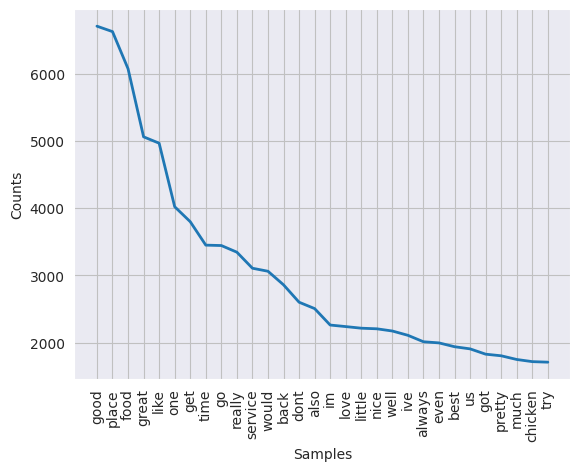

<Axes: xlabel='Samples', ylabel='Counts'>

In [25]:
words_split = []
for i in range(0,9999):
    for word in yelp_text_allstars['Text'][i]:
        words_split.append(word)
FreqDist(words_split).plot(30, cumulative=False)

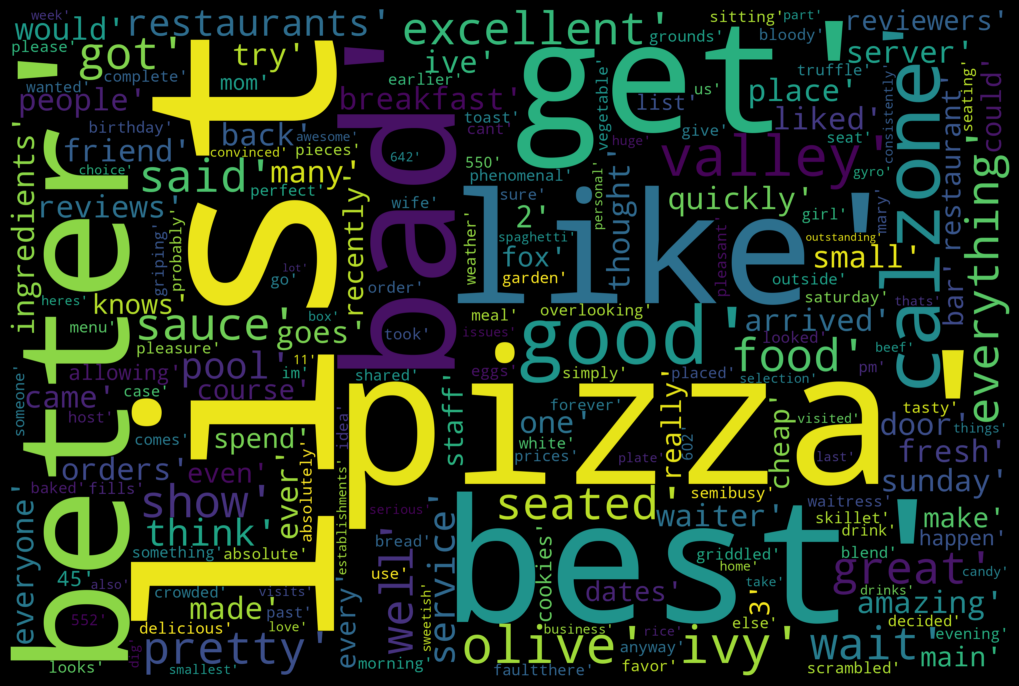

In [26]:
yelp_allstars_text = yelp_text_allstars['Text'].values

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(yelp_allstars_text))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

# Build up ML Model


In [27]:
X = yelp_df['Text']
y = yelp_df['Stars']
cv = CountVectorizer()
X = cv.fit_transform(X)

test_size = np.linspace(0.1, 1, num=9, endpoint=False)
random_state = np.arange(0, 43)
grid_results= []
for testsize in test_size:
    for randomstate in random_state:
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=randomstate)
            mnb = MultinomialNB()
            mnb.fit(X_train, y_train)
            y_test_pred = mnb.predict(X_test)
            grid_results.append([testsize, randomstate, mean_squared_error(y_test, y_test_pred)])
            grid_frame = pd.DataFrame(grid_results)
            grid_frame.rename(columns={0:'Test Size', 1:'Random State', 2:'MSE of Test'}, inplace=True)
        except Exception:
            print(Exception.with_traceback())
            print('error')
            continue

min_test_mse = grid_frame[grid_frame['MSE of Test'] == grid_frame['MSE of Test'].min()]
min_test_mse

,Test Size,Random State,MSE of Test
21,0.1,21,0.99


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=21)
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_test_pred = mnb.predict(X_test)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           1       0.76      0.51      0.61        69
           2       0.56      0.10      0.17        92
           3       0.24      0.12      0.16       137
           4       0.45      0.68      0.55       373
           5       0.60      0.56      0.58       329

    accuracy                           0.50      1000
   macro avg       0.52      0.40      0.41      1000
weighted avg       0.51      0.50      0.48      1000



# ML using TF-IDF

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document, measuring how frequently a term occures in document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears, measuring how important a term is.

In [29]:
tfidf_transformer = TfidfTransformer().fit(X)
X = tfidf_transformer.transform(X)

grid_results= []
for testsize in test_size:
    for randomstate in random_state:
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=randomstate)
            mnb = MultinomialNB()
            mnb.fit(X_train, y_train)
            y_test_pred = mnb.predict(X_test)
            grid_results.append([testsize, randomstate, mean_squared_error(y_test, y_test_pred)])
            grid_frame = pd.DataFrame(grid_results)
            grid_frame.rename(columns={0:'Test Size', 1:'Random State', 2:'MSE of Test'}, inplace=True)
        except Exception:
            print(Exception.with_traceback())
            print('error')
            continue

min_test_mse = grid_frame[grid_frame['MSE of Test'] == grid_frame['MSE of Test'].min()]
min_test_mse

,Test Size,Random State,MSE of Test
31,0.1,31,1.405


In [30]:
warnings.filterwarnings("ignore")
pipeline = Pipeline([('bow', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('classifier', MultinomialNB())])

X = yelp_df['Text']
y = yelp_df['Stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=31)
pipeline.fit(X_train, y_train)
y_test_pred = pipeline.predict(X_test)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        61
           2       0.00      0.00      0.00        99
           3       0.00      0.00      0.00       144
           4       0.40      0.94      0.56       358
           5       0.78      0.35      0.48       338

    accuracy                           0.46      1000
   macro avg       0.24      0.26      0.21      1000
weighted avg       0.41      0.46      0.36      1000



In [31]:
yelp_df12 = yelp_df[(yelp_df.Stars==1) | (yelp_df.Stars==5)]
X = yelp_df12['Text']
y = yelp_df12['Stars']
cv = CountVectorizer()
X = cv.fit_transform(X)

test_size = np.linspace(0.1, 1, num=9, endpoint=False)
random_state = np.arange(0, 43)
grid_results= []
for testsize in test_size:
    for randomstate in random_state:
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=randomstate)
            mnb = MultinomialNB()
            mnb.fit(X_train, y_train)
            y_test_pred = mnb.predict(X_test)
            grid_results.append([testsize, randomstate, mean_squared_error(y_test, y_test_pred)])
            grid_frame = pd.DataFrame(grid_results)
            grid_frame.rename(columns={0:'Test Size', 1:'Random State', 2:'MSE of Test'}, inplace=True)
        except Exception:
            print(Exception.with_traceback())
            print('error')
            continue

min_test_mse = grid_frame[grid_frame['MSE of Test'] == grid_frame['MSE of Test'].min()]
min_test_mse

,Test Size,Random State,MSE of Test
24,0.1,24,0.899756
36,0.1,36,0.899756


In [32]:
pipeline = Pipeline([('bow', CountVectorizer()),
                     ('classifier', MultinomialNB())])

X = yelp_df12['Text']
y = yelp_df12['Stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=36)
pipeline.fit(X_train, y_train)
y_test_pred = pipeline.predict(X_test)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           1       0.88      0.69      0.77        67
           5       0.94      0.98      0.96       342

    accuracy                           0.93       409
   macro avg       0.91      0.83      0.87       409
weighted avg       0.93      0.93      0.93       409



These precision results show that we can predict highest and lowest levels with very high accuracy, indicating that we can just focus on these two levels and summarize what yelp should keep when it gets highest star and what it should imporve when it gets lowest star. And these summarizations will come from words frequency analysis which has been conducted above.